# embedding

## 词语义表征

自然语言处理的的首要目的是识别文本语义。

例如在新闻分类任务，对于文本“全红婵获得了跳水冠军”需要分类为“运动”类的新闻

如果以语义分析角度，通过提取“主谓宾“语法关系，发现名词 ”跳水“， 成为了分类成功的关键。

我们需要识别两种语义模式：

1. word-level : 即上述例子中，我们仅通过 “跳水” 词就能进行分类
2. context-level : 我们需要将文本中每个词进行相关性联系, 推导出分类

毫无疑问的是，word-level更简单，毕竟词的属性是 独立的，而 context-level 是复杂的，例如：

“小冬瓜真有两把刷子“ 中的 ”刷子“， 从 word-level 来看是具体的实体，而从 context-level 来看，“刷子” 代表的是抽象的 “能力”。

**本 notebook 从 word-level 角度展开 “word” 的表示，再到复杂的 “context” 级别的语义表征。**

## 词如何表示

token 可以通过向量表示（这是约定速成的方法），向量维度越高，那么蕴含的信息则越丰富。

表示通常有三种方法:

1. one-hot: 将离散数据 转化成 离散向量
2. embedding：将离散数据 转化成 连续向量
3. vector-quant：将连续数据 转化为 离散数据（ CV常用，本 lecture 不涉及）

### one-hot

对于词表中包含 5 个token : `{'i':1, 'love':2, 'cat':3, 'you':4, '!':5}`:

对于文本“I love you” 中的 三个 token （忽略空格），则可以用 `3x5` 矩阵表示，行代表 一个 one-hot 向量。

one-hot 概念是，**一个零向量里， 仅有一个维度有非零值。**

|      | I    | Love | Cat  | You  | !    |
| ---- | ---- | ---- | ---- | ---- | ---- |
| I    | 1    | 0    | 0    | 0    | 0    |
| Love | 0    | 1    | 0    | 0    | 0    |
| You  | 0    | 0    | 0    | 1    | 0    |

one-hot 问题在于, 主流语言的词表大小 `128,000` , 高维稀疏, 表示低效。

### one-hot pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
torch.manual_seed(42)

# init
size, length, batch = 7, 4, 2
x = torch.randint(0, size, (batch, length))
print(x)

# one-hot
one_hot = F.one_hot(x, num_classes=size)
print(one_hot)

# # 手动实现 one-hot
# one_hot = torch.zeros(batch, length, size)
# one_hot.scatter_(2, x.unsqueeze(2), 1)
# print(one_hot)

# 手动实现——广播
one_hot = torch.zeros(batch, length, size, dtype=torch.long)
# 正确的高级索引：需要为每个维度提供对应的索引
one_hot[torch.arange(batch).unsqueeze(1), torch.arange(length), x] = 1
print(one_hot)

# 手动实现——scatter_
one_hot = torch.zeros(batch, length, size, dtype=torch.long)
one_hot.scatter_(2, x.unsqueeze(2), 1)
print(one_hot)

tensor([[1, 2, 4, 5],
        [4, 3, 5, 5]])
tensor([[[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0]]])
tensor([[[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0]]])
tensor([[[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0]]])


### embedding

**embedding** 概念：将高维离散向量 “嵌入” 到低维“连续”向量，

embedding 在数学上是“操作”，在 NLP 里是指名词 “嵌入向量”， **word embedding** 是 **词嵌入向量** 或 **词嵌入**（嵌入/向量 两者意义重复，一般用“词嵌入”来表示向量）


我们仍以向量来表示词，相较于 one-hot 用离散方式来表示词信息，而 embedding 则以 **特征视角** 来表示词：

- “王“ 字，它有 ”姓氏“，”中文“，“名词”等属性；
- “瓜” 字，它有“植物”，“水果” “名词”，“中文”,"重量:3.4kg"等属性；
- “play” 字，它有 “动词”,"英文" 属性

显式的可以表示各个词元的属性, 其表示更丰富

|        | 姓氏 | 中文 | 名词 | 植物 | 水果 | 中文 | 重量 | 动词 | 英文 |
| ------ | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| `王`   | 1    | 1    | 1    | 0    | 0    | 0    | 0    | 0    | 0    |
| `瓜`   | 0    | 1    | 1    | 1    | 1    | 0    | 3.4  | 0    | 0    |
| `play` | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 1    | 1    |

对于瓜的 embedding 表示为 `[0, 1, 1, 1, 1, 0, 3.4, 0, 0]`


这种方式的问题是: 我们要手工设计多维特征表示, 因此我们要的 embedding 特性为

1. latent-feature 
2. 连续
3. 自动化特征表示

In [4]:
print(x)

# pytorch 实现
embedding_layer = nn.Embedding(size, 3)
print("nn.Embedding 输出:")
print(embedding_layer(x))

# 手动实现: embedding 本质就是 **查表**！
# E 是一个 (vocab_size, embed_dim) 的矩阵，每一行代表一个 token 的 embedding
# 用 token_id 作为行索引，取出对应的行向量
E = torch.randn(size, 3)  # (vocab_size=7, embed_dim=3)
input_embd = E[x]  # x 的每个元素当作行号，去 E 里取对应的行
print("\n手动实现的 embedding:")
print(input_embd)

# 验证：用相同的 E 初始化 nn.Embedding，结果应该一致
embedding_layer.weight.data = E.clone()
print("\n用相同权重的 nn.Embedding 输出:")
print(embedding_layer(x))

tensor([[1, 2, 4, 5],
        [4, 3, 5, 5]])
nn.Embedding 输出:
tensor([[[-0.9342, -0.2483,  0.0915],
         [-2.3169, -0.2168, -1.3847],
         [ 0.3189, -0.0631, -0.8286],
         [ 0.3309, -1.5576,  0.9956]],

        [[ 0.3189, -0.0631, -0.8286],
         [-0.8712, -0.2234,  1.7174],
         [ 0.3309, -1.5576,  0.9956],
         [ 0.3309, -1.5576,  0.9956]]], grad_fn=<EmbeddingBackward0>)

手动实现的 embedding:
tensor([[[-0.9138, -0.6581,  2.2181],
         [ 0.5232,  0.3466, -0.1973],
         [ 0.2311,  0.0566,  0.4263],
         [ 0.5750, -0.6417, -2.2064]],

        [[ 0.2311,  0.0566,  0.4263],
         [-1.0546,  1.2780,  0.1453],
         [ 0.5750, -0.6417, -2.2064],
         [ 0.5750, -0.6417, -2.2064]]])

用相同权重的 nn.Embedding 输出:
tensor([[[-0.9138, -0.6581,  2.2181],
         [ 0.5232,  0.3466, -0.1973],
         [ 0.2311,  0.0566,  0.4263],
         [ 0.5750, -0.6417, -2.2064]],

        [[ 0.2311,  0.0566,  0.4263],
         [-1.0546,  1.2780,  0.1453],
         [ 0.5750, 

embedding layer 就当成是 模型的 一个输入层，随着梯度反向传播，能自然的调整嵌入层参数

注意：这种方式 embedding 表征了什么，完全由训练任务所决定。

## word2vec

上述的 embedding 是由随机初始化而来，是没有语义的。我们需要构建 **学习任务** 来对词进行表征

`word2vec` 是一种 无监督表征词向量的方法。建立假设：**相邻词之间有关联**

给定 "large language model is a helpful agent", 以中心词如 `Models` 找到 2-gram 左右的两个词元，假设为有关联词元，

|   中心词  | large | language | Models | is   | a    | helpful | Agent |
| -------- | ----- | -------- | ------ | ---- | ---- | ------- | ----- |
| Large    | 0     | 1        | 2      | -1   | -1   | -1      | -1    |
| Language | 1     | 0        | 1      | 2    | -1   | -1      | -1    |
| Models   | 2     | 1        | 0      | 1    | 2    | -1      | -1    |
| ....     |       |          |        |      |      |         |       |

注：0表示中心词，句子中的每个词都可以是一个中心词。 1,2 表示距离中心词的距离，-1表示无关，

构建任务，给定一个中心词，预测其向量词，具体如下：

- [vx] -> [vy] : [label]
- Models -> large : True
- Models -> language : True
- Models -> Models : True
- Models -> is : True
- Models -> a : True
- Models -> helpful : False
- Models -> agent : False

In [16]:
# word2vec 配置参数
w2v_vocab_size = 7    # 词表大小
w2v_embed_dim = 5     # 嵌入维度
w2v_seq_len = 100     # 序列长度
w2v_gram = 2          # n-gram 窗口大小

torch.manual_seed(42)

# 模拟一条文本序列（单条）
x_c = torch.randint(0, w2v_vocab_size, (w2v_seq_len,))
print(f"输入序列 x_c: {x_c[:10]}... (前10个token)")

# 初始化 embedding 矩阵 E
E = torch.randn(w2v_vocab_size, w2v_embed_dim, requires_grad=True) 
print(f"\nEmbedding 矩阵 E shape: {E.shape} (vocab_size x embed_dim)")

# 获取序列的 embedding 表示
x_embd = E[x_c, :]
print(f"序列 embedding shape: {x_embd.shape} (seq_len x embed_dim)")

输入序列 x_c: tensor([1, 2, 4, 5, 4, 3, 5, 5, 0, 0])... (前10个token)

Embedding 矩阵 E shape: torch.Size([7, 5]) (vocab_size x embed_dim)
序列 embedding shape: torch.Size([100, 5]) (seq_len x embed_dim)


In [18]:
# 计算两个 word embedding 的相关性
# 核心思想: 中心词 embedding 与 目标词 embedding 的点积越大，表示相关性越高

print(f"序列前5个token: {x_c[:5].tolist()}")
print(f"token {x_c[2].item()} 的 embedding: {E[x_c[2], :].detach()}")

# 1-to-1: 计算中心词与某个词的相关性（点积）
center_idx = 2  # 以第3个token作为中心词
target_idx = 0  # 目标词是第1个token
similarity = E[x_c[center_idx], :] @ E[x_c[target_idx], :].t()
print(f"\n中心词 token[{center_idx}]={x_c[center_idx].item()} 与 目标词 token[{target_idx}]={x_c[target_idx].item()} 的相似度: {similarity.item():.4f}")

# 1-to-n: 中心词与词表中所有词的相关性（logits）
logits = E[x_c[center_idx], :] @ E.t()  # shape: (vocab_size,)
print(f"\n中心词与词表所有词的 logits: {logits.detach()}")

# 转换为概率分布
probs = F.softmax(logits, dim=0)
print(f"概率分布: {probs.detach()}")
print(f"概率之和: {probs.sum().item():.4f}")

序列前5个token: [1, 2, 4, 5, 4]
token 4 的 embedding: tensor([-0.3609, -0.0606,  0.0733,  0.8187,  1.4805])

中心词 token[2]=4 与 目标词 token[0]=1 的相似度: 1.8569

中心词与词表所有词的 logits: tensor([-1.5618,  1.8569,  0.5655,  0.2741,  3.0013,  0.1175, -1.3951])
概率分布: tensor([0.0067, 0.2054, 0.0565, 0.0422, 0.6451, 0.0361, 0.0079])
概率之和: 1.0000


In [19]:
# 创建 Skip-gram 数据集
# Skip-gram: 给定中心词，预测上下文词
# 对于每个中心词，找到其 n-gram 窗口内的上下文词作为正样本

def create_skipgram_dataset(sequence, gram_size):
    """
    创建 Skip-gram 训练数据
    Args:
        sequence: token序列
        gram_size: 窗口大小（左右各 gram_size 个词）
    Returns:
        center_words: 中心词列表
        context_words: 上下文词列表
    """
    center_words = []
    context_words = []
    seq_len = len(sequence)
    
    for i in range(seq_len):
        # 计算窗口边界
        left_bound = max(0, i - gram_size)
        right_bound = min(seq_len - 1, i + gram_size)
        
        # 遍历窗口内的上下文词
        for j in range(left_bound, right_bound + 1):
            if j != i:  # 排除中心词自身
                center_words.append(sequence[i].item())
                context_words.append(sequence[j].item())
    
    return center_words, context_words

# 创建数据集
dataset_x, dataset_y = create_skipgram_dataset(x_c, w2v_gram)

print(f"序列前5个token: {x_c[:5].tolist()}")
print(f"\n数据集大小: {len(dataset_x)} 对 (中心词, 上下文词)")
print(f"前10个中心词: {dataset_x[:10]}")
print(f"前10个上下文词: {dataset_y[:10]}")
print(f"\n示例解释: 中心词 {dataset_x[0]} 的上下文词有 {dataset_y[0]}")

序列前5个token: [1, 2, 4, 5, 4]

数据集大小: 394 对 (中心词, 上下文词)
前10个中心词: [1, 1, 2, 2, 2, 4, 4, 4, 4, 5]
前10个上下文词: [2, 4, 1, 4, 5, 1, 2, 5, 4, 2]

示例解释: 中心词 1 的上下文词有 2


In [20]:
import torch.optim as optim

# Word2Vec 训练配置
lr = 0.5          # 学习率
num_epochs = 100  # 训练轮数

# 重新初始化 embedding 矩阵（确保 requires_grad=True）
torch.manual_seed(42)
E = torch.randn(w2v_vocab_size, w2v_embed_dim, requires_grad=True)

# 保存初始 embedding 用于对比
E_init = E.detach().clone()

def train_step(center_words, target_words, embedding_matrix, learning_rate):
    """
    Word2Vec 单步训练
    Args:
        center_words: 中心词 token id 列表
        target_words: 目标词 token id 列表  
        embedding_matrix: 嵌入矩阵 (vocab_size x embed_dim)
        learning_rate: 学习率
    Returns:
        loss: 当前步的损失值
        embedding_matrix: 更新后的嵌入矩阵
    """
    # 前向传播: 中心词 embedding 与所有词 embedding 计算相似度
    # center_embeds: (num_samples x embed_dim)
    # logits: (num_samples x vocab_size)
    center_embeds = embedding_matrix[center_words, :]
    logits = center_embeds @ embedding_matrix.t()
    
    # 计算交叉熵损失: 预测目标词的概率分布
    labels = torch.tensor(target_words, dtype=torch.long)
    loss = F.cross_entropy(logits, labels)
    
    # 反向传播
    loss.backward()
    
    # 手动梯度下降更新（不使用 optimizer）
    with torch.no_grad():
        embedding_matrix.data -= learning_rate * embedding_matrix.grad
        embedding_matrix.grad.zero_()
    
    return loss.item(), embedding_matrix

# 训练循环
print(f"开始训练 Word2Vec...")
print(f"初始 embedding E[0]: {E[0,:].detach()}")
print(f"数据集大小: {len(dataset_x)} 样本\n")

losses = []
for epoch in range(num_epochs):
    loss, E = train_step(dataset_x, dataset_y, E, lr)
    losses.append(loss)
    
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

print(f"\n训练后 embedding E[0]: {E[0,:].detach()}")

开始训练 Word2Vec...
初始 embedding E[0]: tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784])
数据集大小: 394 样本

Epoch   0 | Loss: 4.9762
Epoch  20 | Loss: 1.9237
Epoch  40 | Loss: 1.8987
Epoch  60 | Loss: 1.8946
Epoch  80 | Loss: 1.8931
Epoch  99 | Loss: 1.8923

训练后 embedding E[0]: tensor([ 0.5016,  0.7399, -0.1426, -0.8839,  0.6569])


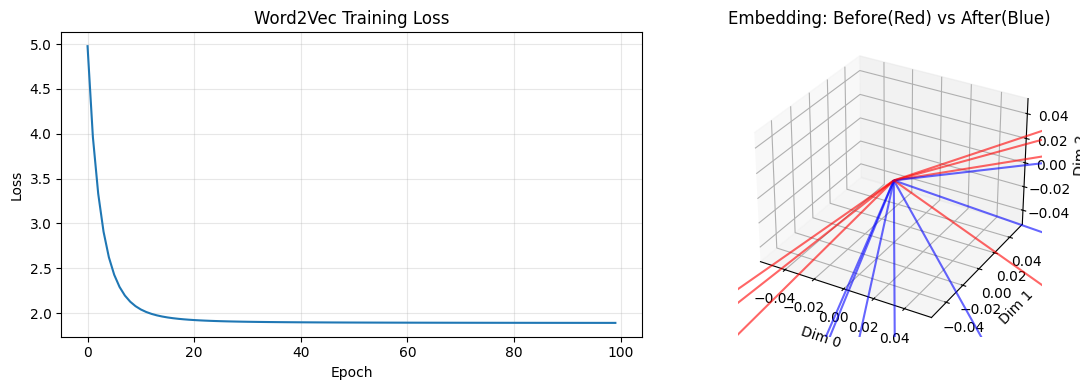


=== 训练后词向量的余弦相似度矩阵 ===
[[1.   0.71 0.5  0.88 0.65 0.84 0.62]
 [0.71 1.   0.89 0.88 0.96 0.96 0.93]
 [0.5  0.89 1.   0.63 0.88 0.87 0.82]
 [0.88 0.88 0.63 1.   0.86 0.89 0.89]
 [0.65 0.96 0.88 0.86 1.   0.93 0.96]
 [0.84 0.96 0.87 0.89 0.93 1.   0.87]
 [0.62 0.93 0.82 0.89 0.96 0.87 1.  ]]


In [ ]:
import matplotlib.pyplot as plt

# 可视化训练损失曲线
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Word2Vec Training Loss')
axes[0].grid(True, alpha=0.3)

# 对比训练前后的 embedding（取前3维可视化）
from mpl_toolkits.mplot3d import Axes3D

ax = fig.add_subplot(122, projection='3d')
# 移除原来的2D axes
axes[1].remove()

# 训练前的 embedding（红色）
for i in range(w2v_vocab_size):
    emb = E_init[i, :3].tolist()
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              normalize=False, arrow_length_ratio=0.15,
              color='red', linewidth=1.5, alpha=0.6)

# 训练后的 embedding（蓝色）
for i in range(w2v_vocab_size):
    emb = E[i, :3].detach().tolist()
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              normalize=False, arrow_length_ratio=0.15,
              color='blue', linewidth=1.5, alpha=0.6)
    ax.text(emb[0], emb[1], emb[2], f'v{i}', fontsize=8)

ax.set_xlabel('Dim 0')
ax.set_ylabel('Dim 1')
ax.set_zlabel('Dim 2')
ax.set_title('Embedding: Before(Red) vs After(Blue)')

plt.tight_layout()
plt.show()

# 验证: 计算词之间的余弦相似度
E_norm = E / E.norm(dim=1, keepdim=True)
cosine_sim = E_norm @ E_norm.t()
print(cosine_sim.detach().numpy().round(2))


### 小结
同理， 对其他中心词可以相同手段处理，分析 word2vec:

1. 从大量语料中，无监督学习词元表征
2. vec 有语义
3. 其特征是面向词元表征的，静态的

示例的 word2vec 存在问题及优化（可选，不影响课程学习）

1. 存在重复前向计算：一个中心词前向计算，既可以得到 预测所有 word 的概率分布。可以复用概率分布。
2. 当 词表大时， 存在大型的矩阵运算，可以采用 **负采样策略** 来减少计算规模

## 文本语义表征

上述的词元表征是 token-level 的，其表示是序列无关的。

如何分析 token 序列语义？

1. word-level 分析: 如训练一个 分类模型，可以对 embedding 分类。 “跳“ embedding 可能被分为 ”新闻类“
2. context-level 分析：将序列 embedding 进行归并形成一个向量，如 $S =\sum_j^N X_j$

### 归并

对于 word2vec 的表示 是 token-level 的

归并特征我们可以视为 context-level 的

In [24]:

bs = 32
seq_len = 100
vocab_size = 7
dim = 5
E = torch.randn(vocab_size, dim)
dim = E.shape[1]
print(dim)
input_ids = torch.randint(0, vocab_size, size=(bs, seq_len)) # 语料
X = E[input_ids.view(-1),:]
X = X.view(bs, seq_len, dim)

seq_embd = X.mean(dim = 1) # seq dimentsion mean
print(seq_embd.shape)

# 对于 batch = 32, 即 一个句子 由原来的 1x100x5 -> 1x5 表示，32个句子为 32x5

5
torch.Size([32, 5])


### 加权组合

"全红婵获得了跳水冠军", 明显 “跳“，”水”词元对 分类任务有更重要的贡献。

定义 权重$w_j$, 来组合词向量. $S =\sum_j^N w_j X_j$, $w_j \in R$

对于上述归并，权重实际上是一种特例。即权重 $S =\sum_j^N w_j X_j$, $w_j = 1/N$

In [25]:
seq = input_ids[0,:]
print(seq.shape)

X_0 = X[0,:,:]
print(X_0.shape)

weight = torch.randn(1, seq_len)
weight = F.softmax(weight, dim = 0)
print(weight.shape)

S = weight @ X_0 
print(S.shape)

torch.Size([100])
torch.Size([100, 5])
torch.Size([1, 100])
torch.Size([1, 5])


### 加权组合扩展

对于加权组合特征，我们用新的视角进行理解

如果对于每个 token， 都有一个独立的 $W \in \mathbb{R} ^{N \times N}$,  $W_i \in \mathbb{R} ^{1 \times N}$



即 $S_i \in \mathbb{R}^d$ 是蕴含 context 信息的 word-embedding

回到一开始的例子“小冬瓜真有两把刷子”, 对于 $S_\text{刷子}$ 即是含有 context-level 的表征。

In [26]:
seq = input_ids[0,:]
print(seq.shape)

X_0 = X[0,:,:]
print(X_0.shape)

weight = torch.randn(seq_len, seq_len)
weight = F.softmax(weight, dim = 1)
print(weight.shape)

S = weight @ X_0 
print(S.shape)
print(S[-1,:].shape) # final embedding as sentece-representation

torch.Size([100])
torch.Size([100, 5])
torch.Size([100, 100])
torch.Size([100, 5])
torch.Size([5])


### 循环神经网络(*)

RNN 类网络构造 $h_t = x_t + w h_{t-1} \in \mathbb{R}^{1 \times d}$, 在最终时刻有完整序列特征

In [27]:
import math
w_rnn = torch.randn(dim, dim) / math.sqrt(dim) # ignore bias
w_mlp = torch.randn(dim, dim) / math.sqrt(dim) 

In [28]:
h_t = torch.zeros(1, dim) 
print(h_t)
print(X_0[0,:])
for i in range(seq_len - 1) :
    h_t = 1/seq_len * X_0[i,:] + h_t @ w_rnn
    h_t = h_t @ w_mlp 
print(h_t)

tensor([[0., 0., 0., 0., 0.]])
tensor([ 1.2683,  1.2243,  0.0981,  1.7423, -1.3527])
tensor([[-0.0011,  0.0042, -0.0148,  0.0061,  0.0077]])


### 总结

序列特征是建立在词特征上进行一定规则的组合。

1. 归并：是一种“一视同仁”重要性的 组合特征方式, 其学习仅是在特征层面学习：$ h_j=X_jW$, $S =\sum_j^N h_j$
2. 加权组合：是一种关注“特征软选择”的组合方式，各个token的权重大小如何定义？如果其加权系数 $w_i,i=1,2,\ldots,N$ 是可学习参数，相较归并特征，增加一个维度序列的学习。它是 **注意力** 机制的核心思想。
3. 循环神经网络：是一种递增的学习表示，在计算上，串型特性使得计算效率低，且时序之间有依赖，不如以上两者直接。

至此，梳理了 文本 -> 分词 -> embedding -> 序列表征，的基础概念。

## 实例：基于 embedding 的文本分类

我们用加权组合方法来做文本分类

In [29]:
# 数据
bs = 32
seq_len = 100
dim = 512
vocab_size = 26
class_num = 3 # 情感分类: negative, neutral, positive


class SimplesLanguageModel(nn.Module):
    def __init__(self, dim = 512, vocab_size = 100, class_num = 2):
        super().__init__()
        self.dim = dim
        self.vocab_size = vocab_size
        self.class_num = class_num
        self.E = nn.Embedding(vocab_size, dim)
        self.w_feat = nn.Linear(dim, dim, bias = False)
        self.weight = nn.Linear(dim, 1)
        self.head = nn.Linear(dim, class_num)
        
    def forward(self, X):
        bs,seq_len = X.shape
        X = self.E(X)
        feat = self.w_feat(X)
        
        weight = self.weight(X) / seq_len

        h = weight.transpose(2,1) @ feat
        
        Y = self.head(h)
        return Y[:,0,:] # logits
        
input_ids = torch.randint(0, vocab_size, size=(bs, seq_len)) # 语料
Y = torch.randint(0, class_num, size=(1, bs))[0]

model = SimplesLanguageModel(dim, vocab_size, class_num)
E_init =  model.E.weight.data.clone()

optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

In [30]:
A = torch.randn(bs,seq_len,dim)
model.weight( A ).shape

torch.Size([32, 100, 1])

In [31]:
for i in range(1000):
    optimizer.zero_grad()
    Y_pred = model(input_ids)

    loss = loss_fn(Y_pred, Y)   
    if i % 100 == 0:
        print(loss)
    loss.backward()
    optimizer.step()

tensor(1.0920, grad_fn=<NllLossBackward0>)
tensor(0.9423, grad_fn=<NllLossBackward0>)
tensor(0.7389, grad_fn=<NllLossBackward0>)
tensor(0.5137, grad_fn=<NllLossBackward0>)
tensor(0.3767, grad_fn=<NllLossBackward0>)
tensor(0.2968, grad_fn=<NllLossBackward0>)
tensor(0.3653, grad_fn=<NllLossBackward0>)
tensor(0.2725, grad_fn=<NllLossBackward0>)
tensor(0.2381, grad_fn=<NllLossBackward0>)
tensor(0.2026, grad_fn=<NllLossBackward0>)


In [32]:
model.E.weight.data
print(model.E.weight.data.shape)

torch.Size([26, 512])


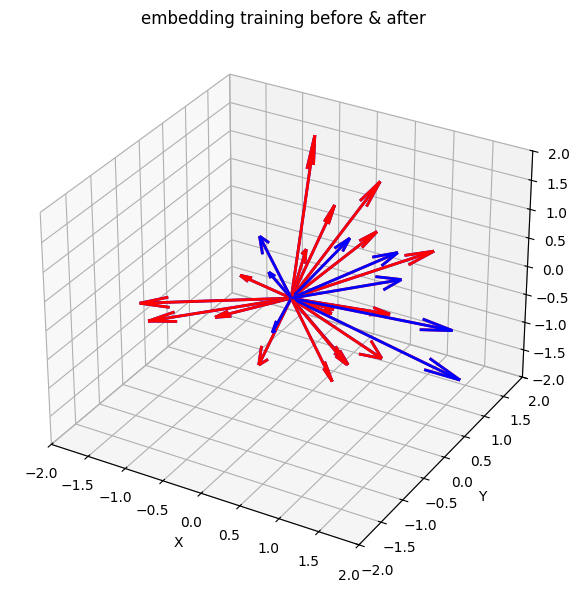

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

embds = model.E.weight.data[:, :3].tolist()
embds_init =  E_init[:, :3].tolist()

for emb in embds:
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              # length=1.0, 
              normalize=False,   # 不自动归一化
              arrow_length_ratio=0.2,
              color='blue',
              linewidth=2)
for emb in embds_init:  
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              # length=1.0, 
              normalize=False,   # 不自动归一化
              arrow_length_ratio=0.2,
              color='red',
              linewidth=2)


max_range = 2
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('embedding training before & after')


plt.tight_layout()
plt.show()

## 手撕 word2vec backward(*)

In [34]:
bs = 1
seq_len = 10
dim = 8
vocab_size = 10
class_num = 3 
dim_out = 9


E = torch.randn(vocab_size, dim, requires_grad=True) #vocab,dim
x = torch.randint(1, vocab_size, (1, seq_len))[0]
label = torch.randn(1, dim_out)
print(x)
W = torch.randn(dim, dim_out)

tensor([3, 3, 6, 1, 8, 9, 6, 3, 4, 2])


### 前向

In [35]:

X = E[x, :]
Y = X @ W
loss = 1/Y.numel() * (( Y - label) ** 2).sum() # MSE
print(loss)

tensor(9.2631, grad_fn=<MulBackward0>)


### 反向手撕

In [36]:
# 反向
dL = 1/Y.numel() * 2 * (Y-label) # v x dim_out
dW = X.t() @ dL 
dX = dL @ W.t() 

dE = torch.zeros(vocab_size, dim)
count = torch.zeros(vocab_size)
for i in range(seq_len):
    dE[x[i],:] += dX[i,:]
    count[x[i]] += 1
print(dE)
print(count)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3531, -0.2015, -0.0974,  0.4909, -0.2048, -0.5206,  0.7611, -0.0542],
        [ 0.0634, -0.0487,  0.0532,  0.0642, -0.0576, -0.3528,  0.5314,  0.0267],
        [ 1.2067, -0.2576, -0.5688,  0.9282, -0.5354, -0.6991,  0.9456,  0.5511],
        [ 0.5350, -0.2865, -0.0870,  0.2046, -0.0571, -0.2985,  0.3955,  0.0521],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3234,  0.4470, -0.2310,  0.3611, -0.1111,  0.3011, -0.6377, -0.2711],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0163, -0.4116, -0.0410,  0.0817, -0.1754, -0.0651,  0.4763,  0.0076],
        [ 0.0665, -0.4382,  0.2026, -0.2506, -0.0647, -0.3138,  0.8376,  0.1913]],
       grad_fn=<CopySlices>)
tensor([0., 1., 1., 3., 1., 0., 2., 0., 1., 1.])


### 反向-by-pytorch autograd

In [37]:
# pytorch 自动求导
X = E[x, :]
Y = X @ W
loss_fn = nn.MSELoss()
loss = loss_fn(Y, label)
print(loss)
loss.backward()
E.grad

tensor(9.2631, grad_fn=<MseLossBackward0>)


/Users/zhangjunmengyang/miniforge3/envs/llm_tool/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1, 9])) that is different to the input size (torch.Size([10, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3531, -0.2015, -0.0974,  0.4909, -0.2048, -0.5206,  0.7611, -0.0542],
        [ 0.0634, -0.0487,  0.0532,  0.0642, -0.0576, -0.3528,  0.5314,  0.0267],
        [ 1.2067, -0.2576, -0.5688,  0.9282, -0.5354, -0.6991,  0.9456,  0.5511],
        [ 0.5350, -0.2865, -0.0870,  0.2046, -0.0571, -0.2985,  0.3955,  0.0521],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3234,  0.4470, -0.2310,  0.3611, -0.1111,  0.3011, -0.6377, -0.2711],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0163, -0.4116, -0.0410,  0.0817, -0.1754, -0.0651,  0.4763,  0.0076],
        [ 0.0665, -0.4382,  0.2026, -0.2506, -0.0647, -0.3138,  0.8376,  0.1913]])